In [1]:
import scanpy as scanpy
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import pandas as pd
import SEACells

In [2]:
adata = sc.read_h5ad('/data_nfs/og86asub/datasets/cellxgene/blood_sc/raw/988defcd-7e39-4d07-91b9-a9853af1e769.h5ad')

biomart = pd.read_csv('/data_nfs/og86asub/scFL-Green/raw/biomart.txt', sep = '\t')
biomart = biomart.loc[:,["Gene stable ID", 'Gene name']]
biomart = biomart.drop_duplicates()



In [3]:
selected_celltypes = ['myeloid leukocyte', 't cell', 'b cell']
output_file_name = ['monocyte', 't_cell', 'b_cell']
obs_var = 'broad_cell_class'
i = 0

In [4]:
adata = adata[adata.obs[obs_var] == selected_celltypes[i], :]

In [5]:
# Replace gene names with ensemble ids.
adata.var = adata.var.reset_index()
adata.var = adata.var.merge(biomart, left_on='ensg', right_on='Gene stable ID', how='left')


In [ ]:

adata.var['keep'] = ~pd.isna(adata.var['Gene name'])
adata = adata[:, adata.var.keep]
# mitochondrial genes (already annotated)
#adata.var["mt2"] = adata.var['Gene name'].str.startswith(("MT-"))
# ribosomal genes
#Duplication fixes weird pandas errror.
adata.var["ribo"] = adata.var['Gene name'].str.startswith("RPS|RPL")
adata.var["ribo"] = adata.var['Gene name'].str.startswith("RPS|RPL")
# hemoglobin genes.
adata.var["hb"] = adata.var['Gene name'].str.contains("^HB[^(P)]")


/tmp/ipykernel_397930/346361423.py:7: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["ribo"] = adata.var['Gene name'].str.startswith("RPS|RPL")
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

adata.obs["mt_outlier"] = (adata.obs["pct_counts_mt"] > 10)

adata = adata[ (~adata.obs.mt_outlier)].copy()
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.filter_cells(adata, min_genes=200)

scales_counts = sc.pp.normalize_total(adata, target_sum=10000, inplace=False)
adata.layers['counts'] = scales_counts["X"]
adata.layers["log1p"] = sc.pp.log1p(adata.layers['counts'], copy=True)
sc.pp.highly_variable_genes(adata, layer="log1p", n_top_genes=4000)

sc.pp.scale(adata, layer = 'log1p')
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True, layer='log1p')
sc.pp.neighbors(adata)
#sc.tl.umap(adata)

/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)


In [8]:
n_SEACells = int(np.floor(adata.shape[0]/75))
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10


model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

model.construct_kernel_matrix()
M = model.kernel_matrix

model.initialize_archetypes()
model.fit(min_iter=10, max_iter=50)

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/22809 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/22809 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/22809 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 290 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 24/24 [00:00<00:00, 57.92it/s]


Selecting 14 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00261
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Converged after 45 iterations.


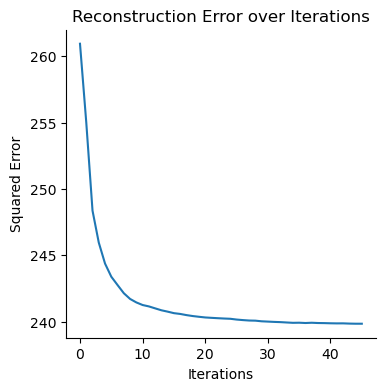

In [9]:
model.plot_convergence()

In [10]:
SEACell_ad = SEACells.core.summarize_by_SEACell(adata, SEACells_label='SEACell', summarize_layer='X')

100%|██████████| 304/304 [00:03<00:00, 84.55it/s]
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/SEACells/plot.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mcs = umap.groupby("SEACell").mean().reset_index()


/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/seaborn/relational.py:438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


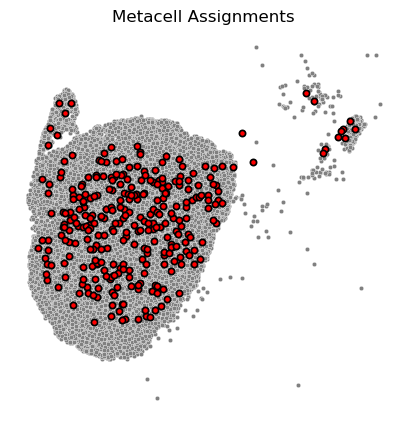

In [11]:
SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=False)

/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/SEACells/plot.py:130: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby("SEACell").count().iloc[:, 0], bins=bins)


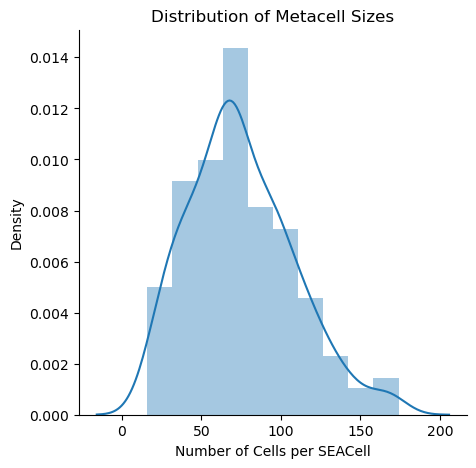

,size
SEACell,
SEACell-0,61
SEACell-1,59
SEACell-10,113
SEACell-100,43
SEACell-101,61
...,...
SEACell-95,144
SEACell-96,21
SEACell-97,103


In [12]:
SEACells.plot.plot_SEACell_sizes(adata, bins=10)

In [13]:
sc.pp.normalize_per_cell(SEACell_ad)
sc.pp.scale(SEACell_ad)
SEACell_ad.write(f"/data_nfs/og86asub/datasets/cellxgene/blood_sc/metacells/{output_file_name[i]}.h5ad")


/tmp/ipykernel_397930/2130533060.py:1: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(SEACell_ad)
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:591: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/data_nfs/og86asub/GRN-FinDeR/.pixi/envs/default/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
